fatal: destination path 'neurogym' already exists and is not an empty directory.
/content/neurogym/neurogym
Obtaining file:///content/neurogym/neurogym
ERROR: file:///content/neurogym/neurogym does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.
Approx steps per trial (CTX): 108
Using seq_len (CTX) = 128
CTX input size: 5
CTX output size: 3
CTX inputs shape (SeqLen, Batch, Dim): (128, 16, 5)
CTX targets shape (SeqLen, Batch): (128, 16)
Baseline net (CTX, 2d):
 RNNNet(
  (rnn): LeakyRNN(
    (input2h): Linear(in_features=5, out_features=128, bias=True)
    (h2h): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc): Linear(in_features=128, out_features=3, bias=True)
)
Training Baseline LeakyRNN (CTX, 2d) on ContextDecisionMaking-v0...


/usr/local/lib/python3.12/dist-packages/gymnasium/envs/registration.py:481: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['paper_link', 'paper_name', 'tags']
  logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.seed to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.seed` for environment variables or `env.get_wrapper_attr('seed')` that will search the reminding wrappers.
  logger.warn(


[Baseline LeakyRNN (CTX, 2d)] step  100 | loss 0.7580 | time 5.6s
[Baseline LeakyRNN (CTX, 2d)] step  200 | loss 0.7116 | time 10.3s
[Baseline LeakyRNN (CTX, 2d)] step  300 | loss 0.7178 | time 15.7s
[Baseline LeakyRNN (CTX, 2d)] step  400 | loss 0.7130 | time 20.4s
[Baseline LeakyRNN (CTX, 2d)] step  500 | loss 0.6148 | time 25.3s
[Baseline LeakyRNN (CTX, 2d)] step  600 | loss 0.5341 | time 30.8s
[Baseline LeakyRNN (CTX, 2d)] step  700 | loss 0.4244 | time 35.5s
[Baseline LeakyRNN (CTX, 2d)] step  800 | loss 0.3724 | time 41.3s
[Baseline LeakyRNN (CTX, 2d)] step  900 | loss 0.3568 | time 45.9s
[Baseline LeakyRNN (CTX, 2d)] step 1000 | loss 0.3337 | time 51.2s
[Baseline LeakyRNN (CTX, 2d)] step 1100 | loss 0.3576 | time 56.1s
[Baseline LeakyRNN (CTX, 2d)] step 1200 | loss 0.3389 | time 60.8s
[Baseline LeakyRNN (CTX, 2d)] step 1300 | loss 0.3433 | time 66.2s
[Baseline LeakyRNN (CTX, 2d)] step 1400 | loss 0.3436 | time 70.8s
[Baseline LeakyRNN (CTX, 2d)] step 1500 | loss 0.3284 | time 77

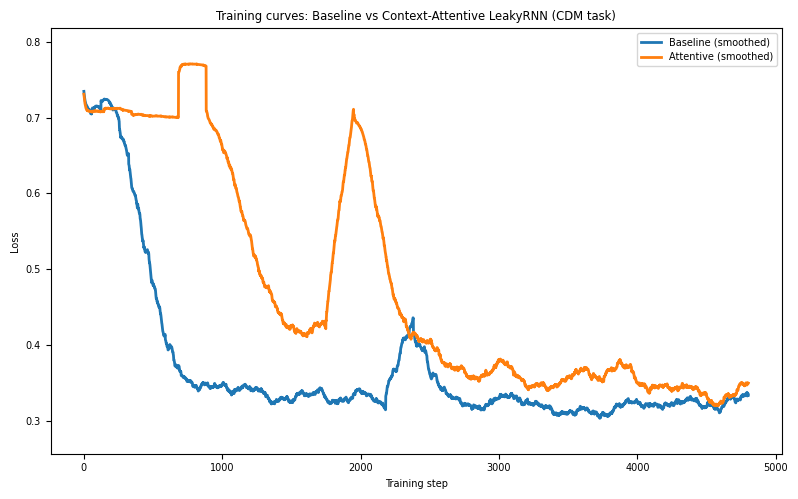


CTX Baseline trial accuracy (2d): 0.925
CTX Attentive trial accuracy (2d): 0.94
Baseline activity shape (T, trials, H): (107, 200, 128)
Attentive activity shape (T, trials, H): (107, 200, 128)
Time axis length: 107


In [4]:

!pip install gym
!git clone https://github.com/gyyang/neurogym.git
%cd neurogym/
!pip install -e .

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import time
import neurogym as ngym
import math
import random
from torch.nn import functional as F

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

SEED = 0
set_seed(SEED)


task_name = 'ContextDecisionMaking-v0'

ctx_timing = {
    'fixation': 300,
    'stimulus': 750,
    'delay':    1000,
    'decision': 100,
}

dt = 20
kwargs = {'dt': dt, 'timing': ctx_timing}

trial_ms    = sum(ctx_timing.values())
trial_steps = math.ceil(trial_ms / dt)
print("Approx steps per trial (CTX):", trial_steps)

seq_len = trial_steps + 20
print("Using seq_len (CTX) =", seq_len)

batch_size = 16

dataset = ngym.Dataset(task_name,
                       env_kwargs=kwargs,
                       batch_size=batch_size,
                       seq_len=seq_len)
env = dataset.env

input_size  = env.observation_space.shape[0]
output_size = env.action_space.n

print("CTX input size:", input_size)
print("CTX output size:", output_size)

inputs_np, targets_np = dataset()
print('CTX inputs shape (SeqLen, Batch, Dim):', inputs_np.shape)
print('CTX targets shape (SeqLen, Batch):',    targets_np.shape)

# For reference, from the env source (7D version):
# names = ['fixation', 'stim1_mod1', 'stim2_mod1',
#          'stim1_mod2', 'stim2_mod2', 'context1', 'context2']
# Here neurogym>=2.2 compresses to 5D:
#   0: fixation
#   1: stim_mod1 (scalar evidence)
#   2: stim_mod2 (scalar evidence)
#   3: context1
#   4: context2

class LeakyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dt=None, **kwargs):
        super().__init__()
        self.input_size  = input_size
        self.hidden_size = hidden_size
        self.tau = 100.0  # ms

        if dt is None:
            alpha = 1.0
        else:
            alpha = dt / self.tau
        self.alpha = alpha

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h     = nn.Linear(hidden_size, hidden_size)

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        h_new = torch.relu(self.input2h(input) + self.h2h(hidden))
        h_new = hidden * (1 - self.alpha) + h_new * self.alpha
        return h_new

    def forward(self, input, hidden=None):
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        outputs = []
        for t in range(input.size(0)):
            hidden = self.recurrence(input[t], hidden)
            outputs.append(hidden)
        outputs = torch.stack(outputs, dim=0)
        return outputs, hidden


class RNNNet(nn.Module):

    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()
        self.rnn = LeakyRNN(input_size, hidden_size, **kwargs)
        self.fc  = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_output, _ = self.rnn(x)
        out = self.fc(rnn_output)
        return out, rnn_output



class AttentiveRNNNet(nn.Module):
    """

    Input layout (dim = 5):
      0: fixation
      1: stim_mod1      # modality 1 evidence
      2: stim_mod2      # modality 2 evidence
      3: context1       # rule: attend modality 1
      4: context2       # rule: attend modality 2

    We compute two attention weights (one per modality) from a *binarised*
    [context1, context2] vector and multiplicatively gate stim_mod1 and
    stim_mod2 before the leaky RNN sees them. The mapping from rule→attention
    is learned but regularised towards the identity (ctx1→mod1, ctx2→mod2).
    """

    def __init__(self,
                 input_size,
                 hidden_size,
                 output_size,
                 dt=None):
        super().__init__()

        self.stim_mod1_idx = torch.tensor([1], dtype=torch.long)
        self.stim_mod2_idx = torch.tensor([2], dtype=torch.long)
        self.rule_idx      = torch.tensor([3, 4], dtype=torch.long)


        self.rule_to_att = nn.Linear(2, 2, bias=False)
        with torch.no_grad():

            self.rule_to_att.weight.copy_(torch.eye(2))

        self.gain = nn.Parameter(torch.tensor(2.0))

        self.rnn = LeakyRNN(input_size, hidden_size, dt=dt)
        self.fc  = nn.Linear(hidden_size, output_size)

    def apply_attention(self, x):

        raw_rule = x[..., self.rule_idx]

        rule_bin = (raw_rule > 0.5).float()
        att_logits = self.rule_to_att(rule_bin)

        att = torch.softmax(self.gain * att_logits, dim=-1)


        att_mod1 = att[..., 0:1]
        att_mod2 = att[..., 1:2]

        x_att = x.clone()
        x_att[..., self.stim_mod1_idx] = x_att[..., self.stim_mod1_idx] * att_mod1
        x_att[..., self.stim_mod2_idx] = x_att[..., self.stim_mod2_idx] * att_mod2

        return x_att

    def forward(self, x):

        x_att = self.apply_attention(x)
        rnn_output, _ = self.rnn(x_att)
        out = self.fc(rnn_output)
        return out, rnn_output



def train_model(net, dataset, n_steps=5000, print_every=100,
                model_name="model"):
    optimizer = optim.Adam(net.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    running_loss = 0.0
    start_time   = time.time()

    loss_history = []
    step_history = []


    lambda_att = 1e-3

    print(f"Training {model_name} on {task_name}...")
    for i in range(n_steps):
        inputs_np, targets_np = dataset()
        inputs  = torch.from_numpy(inputs_np).float()
        targets = torch.from_numpy(targets_np).long()

        optimizer.zero_grad()

        outputs, rnn_activity = net(inputs)

        mask = (targets > 0)

        if mask.sum() == 0:
            continue

        outputs_dec = outputs[mask]
        labels_dec  = targets[mask]

        loss = criterion(outputs_dec, labels_dec)

        if isinstance(net, AttentiveRNNNet):
            W = net.rule_to_att.weight
            I = torch.eye(2, device=W.device)
            reg = ((W - I) ** 2).sum()
            loss = loss + lambda_att * reg

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loss_history.append(loss.item())
        step_history.append(i + 1)

        if (i + 1) % print_every == 0:
            avg_loss = running_loss / print_every
            elapsed  = time.time() - start_time
            print(f"[{model_name}] step {i+1:4d} | loss {avg_loss:.4f} | time {elapsed:.1f}s")
            running_loss = 0.0

    return net, step_history, loss_history


def smooth(y, window=200):
    y = np.array(y)
    if len(y) < window:
        return y
    kernel = np.ones(window) / window
    return np.convolve(y, kernel, mode='valid')


hidden_size = 128

set_seed(SEED)
baseline_net = RNNNet(input_size=input_size,
                      hidden_size=hidden_size,
                      output_size=output_size,
                      dt=env.dt)
print("Baseline net (CTX, 2d):\n", baseline_net)

baseline_net, base_steps, base_losses = train_model(
    baseline_net,
    dataset,
    n_steps=5000,
    print_every=100,
    model_name="Baseline LeakyRNN (CTX, 2d)"
)

set_seed(SEED)
att_net = AttentiveRNNNet(
    input_size=input_size,
    hidden_size=hidden_size,
    output_size=output_size,
    dt=env.dt
)
print("\nAttentive net (CTX, 2d):\n", att_net)

att_net, att_steps, att_losses = train_model(
    att_net,
    dataset,
    n_steps=5000,
    print_every=100,
    model_name="LeakyRNN + ContextAttention (CTX, 2d)"
)

base_smooth = smooth(base_losses, window=200)
att_smooth  = smooth(att_losses,  window=200)

plt.figure(figsize=(8, 5))
plt.plot(base_steps[:len(base_smooth)], base_smooth,
         linewidth=2, label='Baseline (smoothed)')
plt.plot(att_steps[:len(att_smooth)], att_smooth,
         linewidth=2, label='Attentive (smoothed)')

all_smooth = np.concatenate([base_smooth, att_smooth])
y_min, y_max = all_smooth.min(), all_smooth.max()
margin = 0.1 * (y_max - y_min + 1e-8)
plt.ylim(y_min - margin, y_max + margin)

plt.xlabel("Training step")
plt.ylabel("Loss")
plt.title("Training curves: Baseline vs Context-Attentive LeakyRNN (CDM task)")
plt.legend()
plt.tight_layout()
plt.show()


def test_model(net, env, num_trials=200):

    net.eval()

    trial_infos = []
    activity_dict = {}

    with torch.no_grad():
        for i in range(num_trials):
            env.new_trial()
            ob, gt = env.ob, env.gt
            T = ob.shape[0]

            inputs = torch.from_numpy(ob[:, np.newaxis, :]).float()

            outputs, rnn_activity = net(inputs)
            outputs_np = outputs.numpy()
            rnn_np     = rnn_activity.numpy()

            logits_last = outputs_np[-1, 0, :]
            choice = logits_last.argmax()
            correct = (choice == gt[-1])

            trial_infos.append({
                'trial_index': i,
                'correct': bool(correct),
                'choice': int(choice),
                'gt_last': int(gt[-1]),
            })
            activity_dict[i] = rnn_np[:, 0, :]

    net.train()
    accuracy = np.mean([ti['correct'] for ti in trial_infos])
    return accuracy, trial_infos, activity_dict

baseline_acc, baseline_trials, baseline_activity = test_model(baseline_net, env)
print("\nCTX Baseline trial accuracy (2d):", baseline_acc)

att_acc, att_trials, att_activity = test_model(att_net, env)
print("CTX Attentive trial accuracy (2d):", att_acc)

def stack_activity_dict(activity_dict):
    keys = sorted(activity_dict.keys())
    trial_arrays = [np.asarray(activity_dict[k]) for k in keys]
    data = np.stack(trial_arrays, axis=1)
    return data

baseline_act = stack_activity_dict(baseline_activity)
att_act      = stack_activity_dict(att_activity)

print("Baseline activity shape (T, trials, H):", baseline_act.shape)
print("Attentive activity shape (T, trials, H):", att_act.shape)

dt_ms  = getattr(env, "dt", 20.0)
T      = baseline_act.shape[0]
time_s = np.arange(T) * dt_ms / 1000.0
print("Time axis length:", len(time_s))


In [39]:
# 8. Attention weights over time for example trials

def get_attention_traces(att_net, env, max_trials=200):
    """
    Find one ctx1 trial and one ctx2 trial, and return their attention
    weights over time.

    Returns:
        traces: dict with keys 'ctx1', 'ctx2', each -> np.array (T, 2)
                column 0 = alpha_mod1(t), column 1 = alpha_mod2(t)
        lengths: dict with trial lengths (in timesteps) for sanity
    """
    att_net.eval()
    traces = {'ctx1': None, 'ctx2': None}
    lengths = {'ctx1': None, 'ctx2': None}

    with torch.no_grad():
        for i in range(max_trials):
            env.new_trial()
            ob, gt = env.ob, env.gt
            T = ob.shape[0]
            ctx_mean = ob[:, 3:5].mean(axis=0)
            if ctx_mean[0] > ctx_mean[1]:
                ctx_type = 'ctx1'
            else:
                ctx_type = 'ctx2'

            ob_torch = torch.from_numpy(ob[:, np.newaxis, :]).float()

            rule_idx = att_net.rule_idx.to(torch.long)
            raw_rule = ob_torch[..., rule_idx]
            rule_bin = (raw_rule > 0.5).float()

            att_logits = att_net.rule_to_att(rule_bin)
            att = torch.softmax(att_net.gain * att_logits, dim=-1)

            att_np = att.squeeze(1).numpy()


            if traces[ctx_type] is None:
                traces[ctx_type] = att_np
                lengths[ctx_type] = T

            if traces['ctx1'] is not None and traces['ctx2'] is not None:
                break

    att_net.train()
    return traces, lengths

traces, lengths = get_attention_traces(att_net, env)
print("Example ctx1 trial length:", lengths['ctx1'])
print("Example ctx2 trial length:", lengths['ctx2'])


Example ctx1 trial length: 107
Example ctx2 trial length: 107


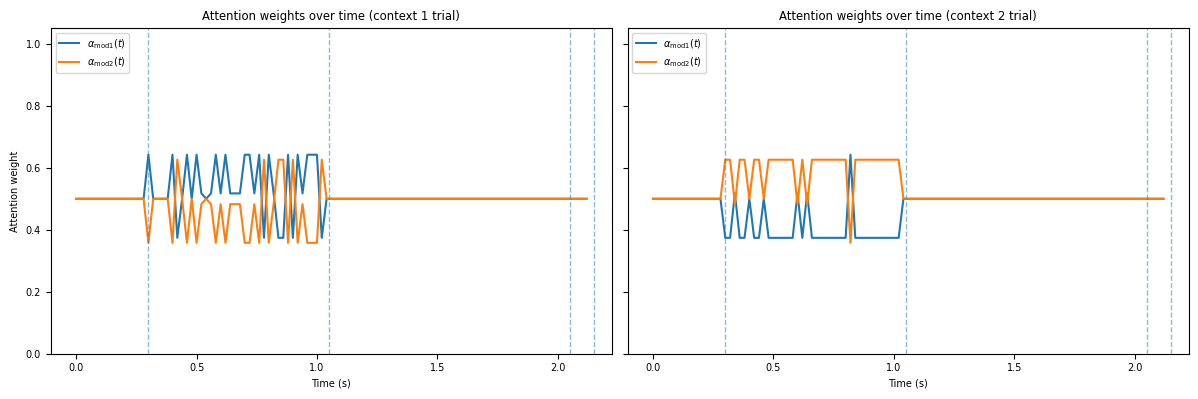

In [40]:

dt_ms  = getattr(env, "dt", 20.0)

t_ctx1 = np.arange(traces['ctx1'].shape[0]) * dt_ms / 1000.0
t_ctx2 = np.arange(traces['ctx2'].shape[0]) * dt_ms / 1000.0

fix_end_s    = ctx_timing['fixation'] / 1000.0
stim_end_s   = (ctx_timing['fixation'] + ctx_timing['stimulus']) / 1000.0
delay_end_s  = (ctx_timing['fixation'] + ctx_timing['stimulus'] +
                ctx_timing['delay']) / 1000.0
dec_end_s    = (ctx_timing['fixation'] + ctx_timing['stimulus'] +
                ctx_timing['delay'] + ctx_timing['decision']) / 1000.0

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

ax = axes[0]
att_ctx1 = traces['ctx1']
ax.plot(t_ctx1, att_ctx1[:, 0], label=r'$\alpha_{\mathrm{mod1}}(t)$')
ax.plot(t_ctx1, att_ctx1[:, 1], label=r'$\alpha_{\mathrm{mod2}}(t)$')

for x in [fix_end_s, stim_end_s, delay_end_s, dec_end_s]:
    ax.axvline(x, linestyle='--', linewidth=1, alpha=0.5)

ax.set_title("Attention weights over time (context 1 trial)")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Attention weight")
ax.set_ylim(0, 1.05)
ax.legend()

ax = axes[1]
att_ctx2 = traces['ctx2']  # (T,2)
ax.plot(t_ctx2, att_ctx2[:, 0], label=r'$\alpha_{\mathrm{mod1}}(t)$')
ax.plot(t_ctx2, att_ctx2[:, 1], label=r'$\alpha_{\mathrm{mod2}}(t)$')

for x in [fix_end_s, stim_end_s, delay_end_s, dec_end_s]:
    ax.axvline(x, linestyle='--', linewidth=1, alpha=0.5)

ax.set_title("Attention weights over time (context 2 trial)")
ax.set_xlabel("Time (s)")
ax.set_ylim(0, 1.05)
ax.legend()

plt.tight_layout()
plt.show()


Learned W_att:
 [[0.8000598  0.23557724]
 [0.19993955 0.7644213 ]]


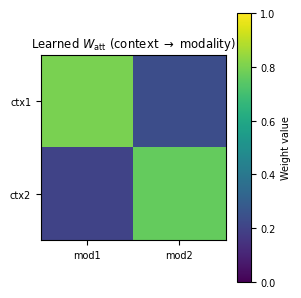

In [8]:


W_att = att_net.rule_to_att.weight.detach().cpu().numpy()
print("Learned W_att:\n", W_att)

plt.figure(figsize=(3, 3))
plt.imshow(W_att, vmin=0.0, vmax=1.0)
plt.colorbar(label="Weight value")
plt.xticks([0, 1], ['mod1', 'mod2'])
plt.yticks([0, 1], ['ctx1', 'ctx2'])
plt.title(r"Learned $W_{\mathrm{att}}$ (context $\rightarrow$ modality)")
plt.tight_layout()
plt.show()
